# Project: Image Classification and Regression
1. [Simple Classification](#task1)<br>
2. [Visualization of the Solution](#task2)<br>
3. [A more Difficult Classification Problem](#task3)<br>
4. [A Regression Problem](#task4)<br>
5. [Image Denoising](#task5)<br>

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
        args = np.argsort(U)
        U = U[args]
        V = V[args]
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

In [0]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, UpSampling2D
import keras
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.utils import np_utils

Using TensorFlow backend.


<a id='task1'></a>
## 1 Simple Classification

In [0]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
100
200


### linear classifier using stochastic gradient descent optimizer

I set the learning rate to be 0.001, and momentum to be 0.9. The optimizer converges as expected.

In [0]:
model = Sequential()
model.add(Dense(3, activation='softmax', input_dim=72*72))
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True),
              metrics=['accuracy'])
model.fit(X_train, np_utils.to_categorical(Y_train, 3), epochs=50, batch_size=64)


Epoch 1/50
300/300 [==============================] - 1s 2ms/step - loss: 1.1250 - acc: 0.4133
Epoch 2/50
300/300 [==============================] - 0s 85us/step - loss: 0.8738 - acc: 0.6500
Epoch 3/50
300/300 [==============================] - 0s 81us/step - loss: 0.7175 - acc: 0.7133
Epoch 4/50
300/300 [==============================] - 0s 71us/step - loss: 0.5918 - acc: 0.7467
Epoch 5/50
300/300 [==============================] - 0s 76us/step - loss: 0.4897 - acc: 0.8433
Epoch 6/50
300/300 [==============================] - 0s 79us/step - loss: 0.4457 - acc: 0.8467
Epoch 7/50
300/300 [==============================] - 0s 76us/step - loss: 0.3940 - acc: 0.9100
Epoch 8/50
300/300 [==============================] - 0s 81us/step - loss: 0.3928 - acc: 0.8300
Epoch 9/50
300/300 [==============================] - 0s 88us/step - loss: 0.3456 - acc: 0.9000
Epoch 10/50
300/300 [==============================] - 0s 81us/step - loss: 0.2996 - acc: 0.9433
Epoch 11/50
300/300 [===================

Check the classifier using a disk example:

In [0]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

The example is correctly classified.

### using Adam optimizer

In [0]:
model_adam = Sequential()
model_adam.add(Dense(3, activation='softmax', input_dim=72*72))
model_adam.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_adam.fit(X_train, np_utils.to_categorical(Y_train, 3), epochs=20, batch_size=32)

Epoch 1/20
300/300 [==============================] - 0s 497us/step - loss: 2.2626 - acc: 0.4233
Epoch 2/20
300/300 [==============================] - 0s 99us/step - loss: 1.1104 - acc: 0.5800
Epoch 3/20
300/300 [==============================] - 0s 111us/step - loss: 0.7389 - acc: 0.6833
Epoch 4/20
300/300 [==============================] - 0s 116us/step - loss: 0.4515 - acc: 0.7633
Epoch 5/20
300/300 [==============================] - 0s 118us/step - loss: 0.3422 - acc: 0.9200
Epoch 6/20
300/300 [==============================] - 0s 111us/step - loss: 0.2953 - acc: 0.9500
Epoch 7/20
300/300 [==============================] - 0s 109us/step - loss: 0.2702 - acc: 0.9533
Epoch 8/20
300/300 [==============================] - 0s 110us/step - loss: 0.2756 - acc: 0.8967
Epoch 9/20
300/300 [==============================] - 0s 127us/step - loss: 0.2456 - acc: 0.9067
Epoch 10/20
300/300 [==============================] - 0s 113us/step - loss: 0.2802 - acc: 0.8733
Epoch 11/20
300/300 [=========

We see that Adam optimizer converges faster than SGD. 
Similarly, we can check the classifier using a disk example:

In [0]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model_adam.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

The example is correctly classified.

<a id='task2'></a>
## 2 Visualization of the Solution

In [0]:
cols = model.get_weights()[0]

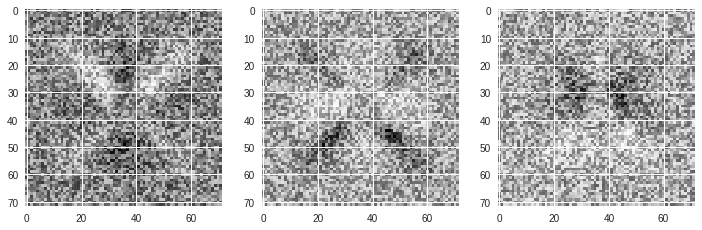

In [0]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 3, 1)
plt.imshow(cols[:, 0].reshape(72, 72))
ax = fig.add_subplot(1, 3, 2)
plt.imshow(cols[:, 1].reshape(72, 72))
ax = fig.add_subplot(1, 3, 3)
plt.imshow(cols[:, 2].reshape(72, 72))

Each image represents the visualization of one column.

<a id='task3'></a>
## 3 A More Difficult Classification Problem

### Create new training set

In [0]:
# increase the number of training samples to 2000
[X_train, Y_train] = generate_dataset_classification(2000, 20, True)

Creating data:
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


### retrain the linear classifier using new training set

In [0]:
# the same linear classifier as in the previous section
model = Sequential()
model.add(Dense(3, activation='softmax', input_dim=72*72))
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True),
              metrics=['accuracy'])
model.fit(X_train, np_utils.to_categorical(Y_train, 3), epochs=100, batch_size=64)

Epoch 1/100
2000/2000 [==============================] - 0s 127us/step - loss: 1.1758 - acc: 0.4215
Epoch 2/100
2000/2000 [==============================] - 0s 71us/step - loss: 1.0275 - acc: 0.5230
Epoch 3/100
2000/2000 [==============================] - 0s 73us/step - loss: 0.9166 - acc: 0.5775
Epoch 4/100
2000/2000 [==============================] - 0s 78us/step - loss: 1.0675 - acc: 0.5335
Epoch 5/100
2000/2000 [==============================] - 0s 86us/step - loss: 0.8606 - acc: 0.5930
Epoch 6/100
2000/2000 [==============================] - 0s 79us/step - loss: 0.8631 - acc: 0.5925
Epoch 7/100
2000/2000 [==============================] - 0s 77us/step - loss: 0.9231 - acc: 0.5815
Epoch 8/100
2000/2000 [==============================] - 0s 73us/step - loss: 0.8731 - acc: 0.5985
Epoch 9/100
2000/2000 [==============================] - 0s 77us/step - loss: 0.7887 - acc: 0.6155
Epoch 10/100
2000/2000 [==============================] - 0s 75us/step - loss: 0.8579 - acc: 0.6115
Epoch 11

### evaluate the linear classifier on a test set

In [0]:
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
100
200


In [0]:
model.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 174us/step


[0.7564015142122904, 0.6133333341280619]

The test accuracy is less than 0.62, which is not an ideal result. Therefore linear classifier doesn't work well on the new dataset. Next, we'll see how Convolutional Neural Network performs on this task.

### train a CNN classifier on the new dataset

In [0]:
# a simple CNN with one convolutional layer, one pooling layer and one fully connected layer
model = Sequential()
model.add(Conv2D(input_shape=(72, 72, 1), filters=16, kernel_size=(5, 5), activation='relu', name="conv_1"))
model.add(MaxPooling2D(pool_size=(2, 2), name="pooling_1"))
model.add(Flatten(name="flatten"))
model.add(Dense(3, activation='softmax', name="dense_1"))
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True),
              metrics=['accuracy'])
model.fit(X_train.reshape(X_train.shape[0], 72, 72, 1), np_utils.to_categorical(Y_train, 3), epochs=100, batch_size=64)

Epoch 1/100
2000/2000 [==============================] - 7s 4ms/step - loss: 1.0808 - acc: 0.3910
Epoch 2/100
2000/2000 [==============================] - 7s 4ms/step - loss: 1.0074 - acc: 0.4885
Epoch 3/100
2000/2000 [==============================] - 7s 3ms/step - loss: 0.9220 - acc: 0.5475
Epoch 4/100
2000/2000 [==============================] - 7s 3ms/step - loss: 0.8580 - acc: 0.5650
Epoch 5/100
2000/2000 [==============================] - 7s 3ms/step - loss: 0.8227 - acc: 0.6145
Epoch 6/100
2000/2000 [==============================] - 7s 3ms/step - loss: 0.7975 - acc: 0.6250
Epoch 7/100
2000/2000 [==============================] - 7s 3ms/step - loss: 0.7999 - acc: 0.6405
Epoch 8/100
2000/2000 [==============================] - 7s 3ms/step - loss: 0.7768 - acc: 0.6470
Epoch 9/100
2000/2000 [==============================] - 7s 3ms/step - loss: 0.7449 - acc: 0.6685
Epoch 10/100
2000/2000 [==============================] - 7s 3ms/step - loss: 0.7326 - acc: 0.6685
Epoch 11/100
2000/2

### evaluate the CNN classifier on the test set

In [0]:
model.evaluate(X_test.reshape(X_test.shape[0], 72, 72, 1), Y_test)

300/300 [==============================] - 1s 2ms/step


[0.3016618990898132, 0.9066666658719381]

CNN obtained an accuracy around 0.91, much better than linear classifier. This is becaue CNN has the property of translational invariance.

<a id='task4'></a>
## 4 A Regression Problem

### create a dataset for the regression problem

In [0]:
[X_train, Y_train] = generate_dataset_regression(5000, 20)

Creating data:
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


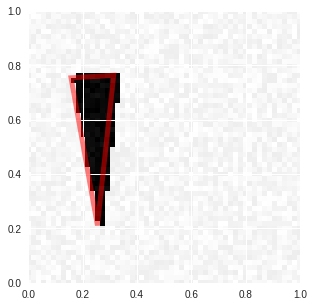

In [0]:
# visualize a training sample
visualize_prediction(X_train[4], Y_train[4])

Train a CNN on the regression dataset.

In [0]:
model = Sequential()
model.add(Conv2D(input_shape=(72, 72, 1), filters=16, kernel_size=(3, 3), activation='relu', name="conv_1"))
model.add(MaxPooling2D(pool_size=(2, 2), name="pooling_1"))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', name="conv_2"))
model.add(MaxPooling2D(pool_size=(2, 2), name="pooling_2"))
model.add(Dropout(rate=0.25, name="dropout_1"))
model.add(Flatten(name="flatten"))
model.add(Dense(128, activation='relu', name="dense_1"))
model.add(Dropout(rate=0.5, name="dropout_2"))
model.add(Dense(6, activation='sigmoid', name="dense_2"))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train.reshape(X_train.shape[0], 72, 72, 1), Y_train, epochs=100, batch_size=64)

Epoch 1/100
5000/5000 [==============================] - 21s 4ms/step - loss: 0.0426
Epoch 2/100
5000/5000 [==============================] - 20s 4ms/step - loss: 0.0254
Epoch 3/100
5000/5000 [==============================] - 20s 4ms/step - loss: 0.0208
Epoch 4/100
5000/5000 [==============================] - 21s 4ms/step - loss: 0.0175
Epoch 5/100
5000/5000 [==============================] - 20s 4ms/step - loss: 0.0153
Epoch 6/100
5000/5000 [==============================] - 20s 4ms/step - loss: 0.0141
Epoch 7/100
5000/5000 [==============================] - 21s 4ms/step - loss: 0.0127
Epoch 8/100
5000/5000 [==============================] - 20s 4ms/step - loss: 0.0123
Epoch 9/100
5000/5000 [==============================] - 20s 4ms/step - loss: 0.0114
Epoch 10/100
5000/5000 [==============================] - 20s 4ms/step - loss: 0.0110
Epoch 11/100
5000/5000 [==============================] - 20s 4ms/step - loss: 0.0102
Epoch 12/100
5000/5000 [==============================] - 20s 4

### evaluate the trained CNN on a test set

In [0]:
[X_test, Y_test] = generate_test_set_regression()

Creating data:
0
100
200


In [0]:
Y_predict = model.predict(X_test.reshape(X_test.shape[0], 72, 72, 1))

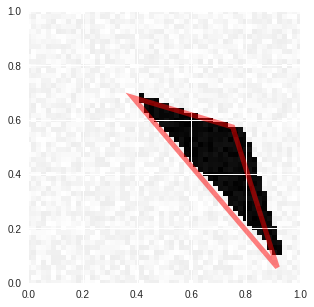

In [0]:
### visualize a test sample
visualize_prediction(X_test[5], Y_predict[5])

We see that our CNN can correctly predict the vertices of the test sample.

<a id='task5'></a>
## 5 Image Denoising

### modify the generate_a_* functions to generate pairs of images

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata1 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata2 = imdata1 + noise * np.random.random(imdata1.size)
    plt.close(fig)
    return imdata1, imdata2

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
        args = np.argsort(U)
        U = U[args]
        V = V[args]
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    return generate_a_drawing(figsize, U, V, noise)

def generate_dataset(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i], Y[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i], Y[i] = generate_a_disk(noise, free_location)
        else:
            X[i], Y[i] = generate_a_triangle(noise, free_location)
    X = X / 255
    Y = (Y + noise) / (255 + 2 * noise)
    return X, Y

In [0]:
# Y_train contains the original images, X_train contains the images with random noise
Y_train, X_train = generate_dataset(5000, 30, True)

Creating data:
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


Text(0.5,1,'image with noise')

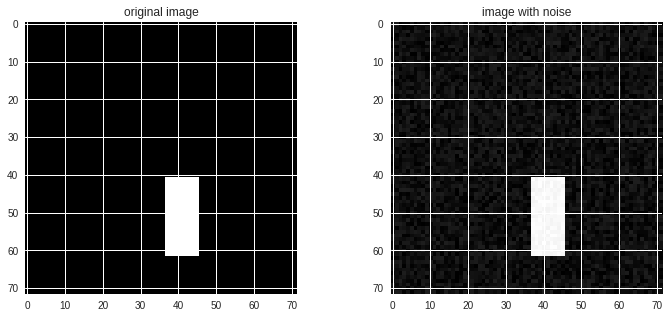

In [0]:
fig = plt.figure(figsize=(12, 5))
# show a sample image with random noise
ax1 = fig.add_subplot(1, 2, 1)
plt.imshow(Y_train[0].reshape(72, 72))
plt.title('original image')
ax2 = fig.add_subplot(1, 2, 2)
plt.imshow(X_train[0].reshape(72, 72))
plt.title('image with noise')

In [0]:
def make_convolutional_autoencoder():
    # encoding
    inputs = Input(shape=(72, 72, 1))
    x = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    x = MaxPooling2D(padding='same')(x)
    x = Conv2D( 8, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D(padding='same')(x)
    x = Conv2D( 8, 3, activation='relu', padding='same')(x)
    encoded = MaxPooling2D(padding='same')(x)    
    
    # decoding
    x = Conv2D( 8, 3, activation='relu', padding='same')(encoded)
    x = UpSampling2D()(x)
    x = Conv2D( 8, 3, activation='relu', padding='same')(x)
    x = UpSampling2D()(x)
    x = Conv2D(16, 3, activation='relu', padding='same')(x) # <= padding='valid'!
    x = UpSampling2D()(x)
    decoded = Conv2D(1, 3, activation='sigmoid', padding='same')(x)
    
    # autoencoder
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', 
                        loss='binary_crossentropy')
    return autoencoder
# create a convolutional autoencoder
autoencoder = make_convolutional_autoencoder()

In [0]:
# summary of the network architecture
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 72, 72, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 8)         584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 8)           0         
__________

In [0]:
# train the autoencoder
autoencoder.fit(X_train.reshape(X_train.shape[0], 72, 72, 1), Y_train.reshape(Y_train.shape[0], 72, 72, 1), epochs=50, batch_size=64)

Epoch 1/50
5000/5000 [==============================] - 43s 9ms/step - loss: 0.3242
Epoch 2/50
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0701
Epoch 3/50
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0266
Epoch 4/50
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0209
Epoch 5/50
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0184
Epoch 6/50
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0169
Epoch 7/50
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0154
Epoch 8/50
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0144
Epoch 9/50
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0134
Epoch 10/50
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0126
Epoch 11/50
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0121
Epoch 12/50
5000/5000 [==============================] - 43s 9ms/step - lo

### check the denoising performance of the trained autoencoder for a test set

In [0]:
Y_test, X_test = generate_dataset(300, 30, True)

Creating data:
0
100
200


In [0]:
Y_predict = autoencoder.predict(X_test.reshape(X_test.shape[0], 72, 72, 1))

Text(0.5,1,'input with noise')

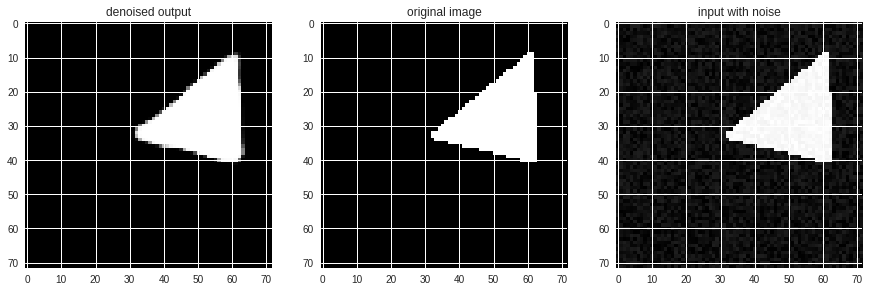

In [0]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1)
plt.imshow(Y_predict[5].reshape(72, 72))
plt.title('denoised output')
ax2 = fig.add_subplot(1, 3, 2)
plt.imshow(Y_test[5].reshape(72, 72))
plt.title('original image')
ax3 = fig.add_subplot(1, 3, 3)
plt.imshow(X_test[5].reshape(72, 72))
plt.title('input with noise')

As shown in the figures above, the autoencoder has successfully denoised the input images.